In [30]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split, RandomizedSearchCV)
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [41]:
data = pd.read_csv('data.csv', index_col='Местное время в Ростове-на-Дону')
data.head()

,T,Po,P,Pa,U,DD,Ff,ff10,ff3,N,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
Местное время в Ростове-на-Дону,,,,,,,,,,,,,,,,,,,,,
01.08.2023 21:00,26.7,749.0,NaN,NaN,43.0,NaN,NaN,NaN,NaN,60%.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01.08.2023 18:00,31.2,748.0,NaN,NaN,34.0,NaN,NaN,NaN,NaN,"90 или более, но не 100%",...,NaN,NaN,NaN,NaN,Осадков нет,12.0,NaN,NaN,NaN,NaN
01.08.2023 15:00,33.8,749.0,NaN,NaN,24.0,NaN,NaN,NaN,NaN,70 – 80%.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01.08.2023 12:00,32.1,750.0,NaN,NaN,34.0,NaN,NaN,NaN,NaN,20–30%.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01.08.2023 09:00,27.4,750.0,NaN,NaN,43.0,NaN,NaN,NaN,NaN,40%.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
data.index += ':00'
data.index

Index(['01.08.2023 21:00:00', '01.08.2023 18:00:00', '01.08.2023 15:00:00',
       '01.08.2023 12:00:00', '01.08.2023 09:00:00', '01.08.2023 06:00:00',
       '01.08.2023 03:00:00', '01.08.2023 00:00:00', '31.07.2023 21:00:00',
       '31.07.2023 18:00:00',
       ...
       '02.01.2010 03:00:00', '02.01.2010 00:00:00', '01.01.2010 21:00:00',
       '01.01.2010 18:00:00', '01.01.2010 15:00:00', '01.01.2010 12:00:00',
       '01.01.2010 09:00:00', '01.01.2010 06:00:00', '01.01.2010 03:00:00',
       '01.01.2010 00:00:00'],
      dtype='object', name='Местное время в Ростове-на-Дону', length=38796)

In [33]:
data.index = pd.to_datetime(data.index, format='mixed')
data.index

DatetimeIndex(['2023-01-08 21:00:00', '2023-01-08 18:00:00',
               '2023-01-08 15:00:00', '2023-01-08 12:00:00',
               '2023-01-08 09:00:00', '2023-01-08 06:00:00',
               '2023-01-08 03:00:00', '2023-01-08 00:00:00',
               '2023-07-31 21:00:00', '2023-07-31 18:00:00',
               ...
               '2010-02-01 03:00:00', '2010-02-01 00:00:00',
               '2010-01-01 21:00:00', '2010-01-01 18:00:00',
               '2010-01-01 15:00:00', '2010-01-01 12:00:00',
               '2010-01-01 09:00:00', '2010-01-01 06:00:00',
               '2010-01-01 03:00:00', '2010-01-01 00:00:00'],
              dtype='datetime64[ns]', name='Местное время в Ростове-на-Дону', length=38796, freq=None)

36720

In [9]:
data['N'].unique()

array(['60%.', '90  или более, но не 100%', '70 – 80%.', '20–30%.',
       '40%.', 'Облаков нет.', '10%  или менее, но не 0', '50%.', '100%.',
       nan,
       'Небо не видно из-за тумана и/или других метеорологических явлений.'],
      dtype=object)

<Axes: xlabel='Местное время в Ростове-на-Дону'>

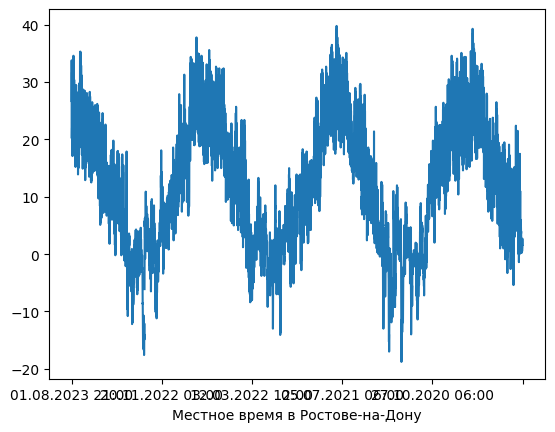

In [42]:
data.iloc[:10000]['T'].plot()